In [1]:
import glob 
import gc
import warnings
import scipy

import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt 

## custom
from dirs import wrfdir, basedir, coorddir, snoteldir, outputsdir, ucladir

plt.style.use('style.mplstyle')
plt.rcParams['font.family'] = 'sans-serif'

warnings.filterwarnings("ignore")

/global/homes/c/cowherd/.conda/envs/resilient-snowpack-estimation/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
coords = xr.open_dataset(f'{coorddir}wrfinput_d02')
lat = coords['XLAT'][0]
lon = coords['XLONG'][0]

In [3]:
## compare the annual snowpack data from 1985 to 2015 from the UCLA reanalysis, SNOTEL sites, and WRF data. include the non BC data as well??

In [4]:
## ucla data
ucla_snotel_data = scipy.io.loadmat(f'{ucladir}/SNOTEL_SWE_WY1985_2021_high_res.mat')
## snotel data
snotel_from_WRF_BC = xr.open_dataset(f'{basedir}/data/tmp/all_snotelWRF_365.nc').rename({'__xarray_dataarray_variable__':'swe'})


In [5]:
snotelmeta = pd.read_csv(snoteldir + 'snotelmeta.csv')

snotel_gdf = gpd.GeoDataFrame(data = {'site_name':snotelmeta.site_name,
                                     'elev': snotelmeta.elev,
                                     'site_number':snotelmeta.site_number,
                                     'state':snotelmeta.state,
                                     'namestr':snotelmeta.namestr,
                                     'startdt':snotelmeta.startdt}, geometry = gpd.points_from_xy(snotelmeta.lon, snotelmeta.lat))
snotel_no_ak = snotel_gdf[snotel_gdf.state != "AK"]


In [6]:
## what's the list of SNOTEL sites?
ucla_snotels = list(ucla_snotel_data['SNOTEL'][0][0][0].flatten()) ## 858 stations
file_list = glob.glob(f"{snoteldir}/snotel*.csv")
print(len(file_list))
my_snotels= [fn.split('.csv')[0].split('snotel')[-1] for fn in file_list] ## 812 stations + snotelmeta
my_snotels = [int(item) for item in my_snotels if item != 'meta']
shared_entries = list(set(my_snotels).intersection(ucla_snotels))
# Find the entries that are not in one of the lists
unique_to_my_snotels = list(set(my_snotels).difference(ucla_snotels))
unique_to_ucla_snotels = list(set(ucla_snotels).difference(my_snotels))
## now make a list of ind for the shared_entries

filtered_snotel = snotel_no_ak[snotel_no_ak['site_number'].isin(shared_entries)]

points = zip(filtered_snotel.geometry.x, filtered_snotel.geometry.y)
x_indices, y_indices = [], []

for point in points:
    longitude, latitude = point
    distances = np.sqrt((lat.values - latitude) ** 2 + (lon.values - longitude) ** 2)
    min_indices = np.unravel_index(np.argmin(distances), distances.shape)
    x_indices.append(min_indices[0])
    y_indices.append(min_indices[1])


813


In [7]:
snotel_data = []
for num in shared_entries:
    file = f"{snoteldir}/snotel{num}.csv"
    df = pd.read_csv(file, parse_dates = True)
    df['Date'] = pd.to_datetime(df['datetime'])
    df = df[(df['Date'].dt.year >= 1980) & (df['Date'].dt.year <= 2015)]
    snotel_data.append(df) 
snotel_df = pd.concat([df.set_index('Date')['SWE'] for df in snotel_data], axis=1)
meansnotel = snotel_df.groupby(snotel_df.index.dayofyear).mean()

gc.collect()

0

In [8]:
wrf_snotel_daily_mean = snotel_from_WRF_BC.mean(dim = 'site').mean(dim = 'gcm').swe

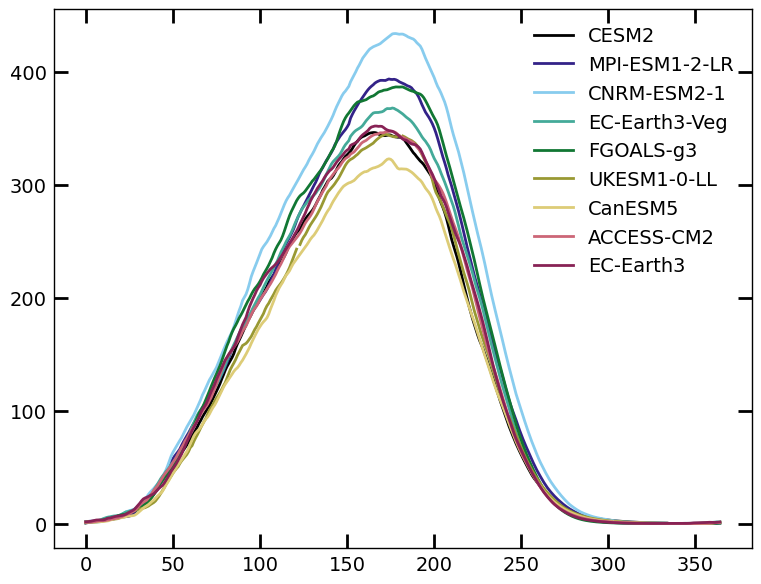

In [9]:
gcms = ['CESM2','MPI-ESM1-2-LR','CNRM-ESM2-1',
        'EC-Earth3-Veg','FGOALS-g3','UKESM1-0-LL',
        'CanESM5','ACCESS-CM2','EC-Earth3']
ig,ax = plt.subplots()
for i,gcm in enumerate(snotel_from_WRF_BC.gcm):
    tmpdata = np.roll(snotel_from_WRF_BC.sel(gcm = gcm).mean(dim = 'site').swe, shift = 92)
    tmpdata[91] = np.nanmean([tmpdata[90], tmpdata[92]])
    ax.plot(tmpdata, label = gcms[i])
ax.legend()
plt.show()

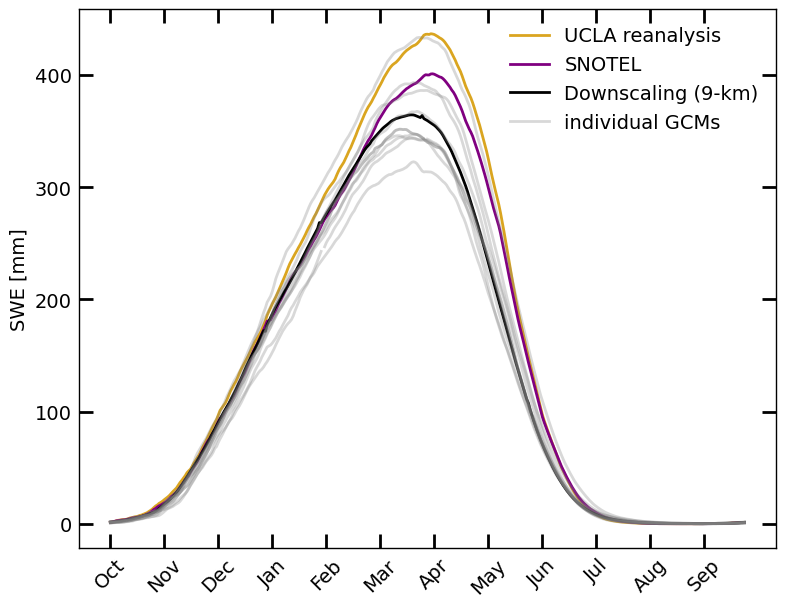

In [10]:
## make figure
wrfcolor = 'black'
snotelcolor = 'purple'
uclacolor = 'goldenrod'
## ucla data 

ucla_mean = np.nanmean(ucla_snotel_data['SWE'][:,0:30,:], axis = (0,1)) * 1000
ucla_sd = np.nanstd(ucla_snotel_data['SWE'][:,0:30,:], axis = (0,1)) * 1000

## snotel from WRF
shifted_wrf_mean = np.roll(wrf_snotel_daily_mean.values.flatten(), shift=90)
#shifted_wrf_sd = np.roll(wrf_snotel_daily_sd.values.flatten(), shift=90)

## snotel station data
snotel_mean = np.nanmean(meansnotel, axis = 1) * 24.5
snotel_sd = np.nanstd(meansnotel, axis = 1) * 24.5
shifted_snotel_mean = np.roll(snotel_mean, shift=92)
shifted_snotel_mean[91] = np.nanmean([shifted_snotel_mean[90], shifted_snotel_mean[92]])
shifted_snotel_sd = np.roll(snotel_sd, shift=92)


## dates ## 

x = np.arange(365)  # 0 to 364

# Create a list of month labels
month_labels = ['Oct', 'Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
## 

fig,ax = plt.subplots()
ax.plot(x, ucla_mean [0:365] , label = 'UCLA reanalysis', color = uclacolor)
ax.plot(x, shifted_snotel_mean[0:365] , label = 'SNOTEL', color = snotelcolor)
ax.plot(shifted_wrf_mean, label = 'Downscaling (9-km)', color = wrfcolor)

for gcm in snotel_from_WRF_BC.gcm:
    tmpdata = np.roll(snotel_from_WRF_BC.sel(gcm = gcm).mean(dim = 'site').swe, shift = 92)
    tmpdata[91] = np.nanmean([tmpdata[90], tmpdata[92]])
    ax.plot(tmpdata, color = 'gray', alpha = 0.3)
ax.plot(tmpdata, color = 'gray', alpha = 0.3, label = 'individual GCMs')

    
ax.set_ylabel('SWE [mm]')
ax.legend()
ax.set_xticks(np.arange(0, 365, 31), month_labels, rotation=45)

fig.savefig(f'{basedir}/figures/ext_climatology.png')

plt.show()

